# Imports

In [1]:
import numpy as np
import pandas as pd
#import swifter
# import pandas_profiling
import pprint
import pickle

from datetime import datetime
import time

import pytz
#from timezonefinder import TimezoneFinder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.preprocessing import OneHotEncoder



## Jupyter Configurations

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)

%matplotlib inline

## Function Definitions

In [3]:
def is_dst(dt=None, timezone="UTC"):
    if dt is None:
        dt = datetime.utcnow()
    timezone = pytz.timezone(timezone)
    timezone_aware_date = timezone.localize(dt, is_dst=None)
    return timezone_aware_date.tzinfo._dst.seconds != 0

def multipleReplace(text, wordDict):
    for key in wordDict:
        text = text.replace(key, wordDict[key])
    return text

## Read Data

In [4]:
%%time

df = pd.read_csv("US_Accidents_Dec19.csv")

print('Imported {:,} rows.'.format(len(df)))

Imported 2,974,335 rows.
CPU times: user 37.3 s, sys: 2.29 s, total: 39.6 s
Wall time: 39.4 s


## Prepare the Datetime values

In [5]:
%%time

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])

df["Duration(s)"] = (df["End_Time"] - df["Start_Time"]) // pd.Timedelta('1s')
df['Start_Hour'] = df["Start_Time"].dt.hour
df['Start_Month'] = df["Start_Time"].dt.month
df['Start_Day'] = df["Start_Time"].dt.strftime("%A")

# Map Day name of week to number
d = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}

df['Start_Day'] = df['Start_Day'].map(d)



CPU times: user 34.7 s, sys: 1.2 s, total: 35.9 s
Wall time: 32.2 s


## One Hot Encoding

In [6]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['Wind_Direction', 'Weather_Condition',
                     'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
                     'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                     'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
                     'Nautical_Twilight', 'Astronomical_Twilight']

df_ohe = encode_and_bind(df, 'Timezone')

for feature in features_to_encode:
    df_ohe = encode_and_bind(df_ohe, feature)
    



# Data Cleaning

## Fill missing numeric values

In [7]:
%%time

df_ohe['Temperature(F)'].fillna(df_ohe['Temperature(F)'].mean(), inplace=True)
df_ohe['Wind_Chill(F)'].fillna(df_ohe['Temperature(F)'], inplace=True)   #Went with Temp due to Wind_Chill.mean() giving values that didn't make sense.
df_ohe['Wind_Speed(mph)'].fillna(df_ohe['Wind_Speed(mph)'].mean(), inplace=True)
df_ohe['Precipitation(in)'].fillna(df_ohe['Precipitation(in)'].mean(), inplace=True)
df_ohe['Humidity(%)'].fillna(df_ohe['Humidity(%)'].mean(), inplace=True)
df_ohe['Pressure(in)'].fillna(df_ohe['Pressure(in)'].mean(), inplace=True)
df_ohe['Visibility(mi)'].fillna(df_ohe['Visibility(mi)'].mean(), inplace=True)



CPU times: user 438 ms, sys: 35.8 ms, total: 474 ms
Wall time: 163 ms


## Split into train/test

In [8]:
print(df_ohe.head())

print(list(df_ohe.columns))

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_ohe, test_size = 0.3, random_state = 126)


    ID    Source    TMC  Severity          Start_Time            End_Time  \
0  A-1  MapQuest  201.0         3 2016-02-08 05:46:00 2016-02-08 11:00:00   
1  A-2  MapQuest  201.0         2 2016-02-08 06:07:59 2016-02-08 06:37:59   
2  A-3  MapQuest  201.0         2 2016-02-08 06:49:27 2016-02-08 07:19:27   
3  A-4  MapQuest  201.0         3 2016-02-08 07:23:34 2016-02-08 07:53:34   
4  A-5  MapQuest  201.0         2 2016-02-08 07:39:07 2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  \
0  39.865147 -84.058723      NaN      NaN          0.01   
1  39.928059 -82.831184      NaN      NaN          0.01   
2  39.063148 -84.032608      NaN      NaN          0.01   
3  39.747753 -84.205582      NaN      NaN          0.01   
4  39.627781 -84.188354      NaN      NaN          0.01   

                                         Description  Number  \
0  Right lane blocked due to accident on I-70 Eas...     NaN   
1  Accident on Brice Rd at Tussing Rd. Expect del...  

In [9]:
print(df_ohe.isnull().sum())

ID                                                      0
Source                                                  0
TMC                                                728071
Severity                                                0
Start_Time                                              0
End_Time                                                0
Start_Lat                                               0
Start_Lng                                               0
End_Lat                                           2246264
End_Lng                                           2246264
Distance(mi)                                            0
Description                                             1
Number                                            1917605
Street                                                  0
Side                                                    0
City                                                   83
County                                                  0
State         

## Scatterplots

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


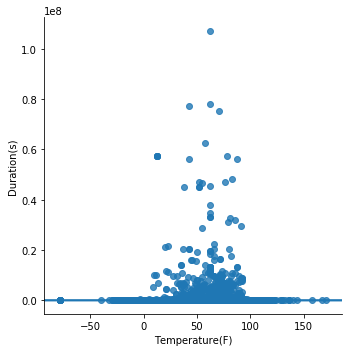

In [10]:
sns.lmplot('Temperature(F)', 'Duration(s)', train)


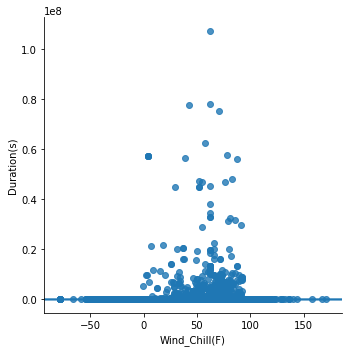

In [11]:
sns.lmplot('Wind_Chill(F)', 'Duration(s)', train)

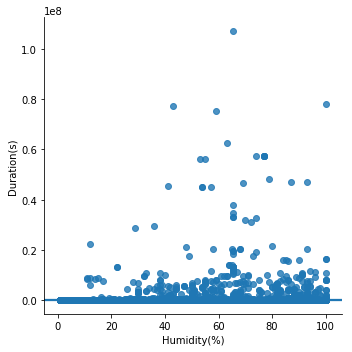

In [12]:
sns.lmplot('Humidity(%)', 'Duration(s)', train)

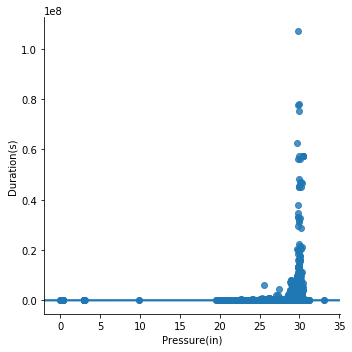

In [13]:
sns.lmplot('Pressure(in)', 'Duration(s)', train)

# Feature Selection
## Random Forest & Gradient Boosting Regressors

In [14]:
predictor_cols = [#'ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time', 
                  #'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 
                  'Distance(mi)', #'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 
                  #'Weather_Timestamp', 
                  'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                  'Wind_Speed(mph)', 'Precipitation(in)', 'Start_Hour', 'Start_Month', 'Start_Day', 
                  'Timezone_US/Central', 'Timezone_US/Eastern', 'Timezone_US/Mountain', 'Timezone_US/Pacific', 
                  'Wind_Direction_CALM', 'Wind_Direction_Calm', 'Wind_Direction_E', 'Wind_Direction_ENE', 'Wind_Direction_ESE', 
                  'Wind_Direction_East', 'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NNE', 'Wind_Direction_NNW', 
                  'Wind_Direction_NW', 'Wind_Direction_North', 'Wind_Direction_S', 'Wind_Direction_SE', 'Wind_Direction_SSE', 
                  'Wind_Direction_SSW', 'Wind_Direction_SW', 'Wind_Direction_South', 'Wind_Direction_VAR', 'Wind_Direction_Variable', 
                  'Wind_Direction_W', 'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Wind_Direction_West', 'Weather_Condition_Blowing Dust', 
                  'Weather_Condition_Blowing Dust / Windy', 'Weather_Condition_Blowing Sand', 'Weather_Condition_Blowing Snow', 
                  'Weather_Condition_Blowing Snow / Windy', 'Weather_Condition_Clear', 'Weather_Condition_Cloudy', 
                  'Weather_Condition_Cloudy / Windy', 'Weather_Condition_Drizzle', 'Weather_Condition_Drizzle / Windy', 
                  'Weather_Condition_Drizzle and Fog', 'Weather_Condition_Dust Whirls', 'Weather_Condition_Fair', 
                  'Weather_Condition_Fair / Windy', 'Weather_Condition_Fog', 'Weather_Condition_Fog / Windy', 'Weather_Condition_Freezing Rain', 
                  'Weather_Condition_Freezing Rain / Windy', 'Weather_Condition_Funnel Cloud', 'Weather_Condition_Hail', 
                  'Weather_Condition_Haze', 'Weather_Condition_Haze / Windy', 'Weather_Condition_Heavy Blowing Snow', 
                  'Weather_Condition_Heavy Drizzle', 'Weather_Condition_Heavy Freezing Drizzle', 'Weather_Condition_Heavy Freezing Rain', 
                  'Weather_Condition_Heavy Ice Pellets', 'Weather_Condition_Heavy Rain', 'Weather_Condition_Heavy Rain / Windy', 
                  'Weather_Condition_Heavy Rain Showers', 'Weather_Condition_Heavy Sleet', 'Weather_Condition_Heavy Smoke', 
                  'Weather_Condition_Heavy Snow', 'Weather_Condition_Heavy Snow / Windy', 'Weather_Condition_Heavy Snow with Thunder', 
                  'Weather_Condition_Heavy T-Storm', 'Weather_Condition_Heavy T-Storm / Windy', 
                  'Weather_Condition_Heavy Thunderstorms and Rain', 'Weather_Condition_Heavy Thunderstorms and Snow', 
                  'Weather_Condition_Heavy Thunderstorms with Small Hail', 'Weather_Condition_Ice Pellets', 
                  'Weather_Condition_Light Blowing Snow', 'Weather_Condition_Light Drizzle', 'Weather_Condition_Light Drizzle / Windy', 
                  'Weather_Condition_Light Fog', 'Weather_Condition_Light Freezing Drizzle', 'Weather_Condition_Light Freezing Fog', 
                  'Weather_Condition_Light Freezing Rain', 'Weather_Condition_Light Freezing Rain / Windy', 'Weather_Condition_Light Hail', 
                  'Weather_Condition_Light Haze', 'Weather_Condition_Light Ice Pellets', 'Weather_Condition_Light Rain', 
                  'Weather_Condition_Light Rain / Windy', 'Weather_Condition_Light Rain Shower', 'Weather_Condition_Light Rain Shower / Windy', 
                  'Weather_Condition_Light Rain Showers', 'Weather_Condition_Light Rain with Thunder', 'Weather_Condition_Light Sleet', 
                  'Weather_Condition_Light Snow', 'Weather_Condition_Light Snow / Windy', 'Weather_Condition_Light Snow Grains', 
                  'Weather_Condition_Light Snow Shower', 'Weather_Condition_Light Snow Showers', 'Weather_Condition_Light Snow and Sleet', 
                  'Weather_Condition_Light Snow and Sleet / Windy', 'Weather_Condition_Light Snow with Thunder', 
                  'Weather_Condition_Light Thunderstorm', 'Weather_Condition_Light Thunderstorms and Rain', 
                  'Weather_Condition_Light Thunderstorms and Snow', 'Weather_Condition_Low Drifting Snow', 'Weather_Condition_Mist', 
                  'Weather_Condition_Mostly Cloudy', 'Weather_Condition_Mostly Cloudy / Windy', 'Weather_Condition_N/A Precipitation', 
                  'Weather_Condition_Overcast', 'Weather_Condition_Partial Fog', 'Weather_Condition_Partial Fog / Windy', 
                  'Weather_Condition_Partly Cloudy', 'Weather_Condition_Partly Cloudy / Windy', 'Weather_Condition_Patches of Fog', 
                  'Weather_Condition_Rain', 'Weather_Condition_Rain / Windy', 'Weather_Condition_Rain Shower', 'Weather_Condition_Rain Showers', 
                  'Weather_Condition_Sand', 'Weather_Condition_Sand / Dust Whirlwinds', 'Weather_Condition_Sand / Dust Whirlwinds / Windy', 
                  'Weather_Condition_Scattered Clouds', 'Weather_Condition_Shallow Fog', 'Weather_Condition_Showers in the Vicinity', 
                  'Weather_Condition_Sleet', 'Weather_Condition_Small Hail', 'Weather_Condition_Smoke', 'Weather_Condition_Smoke / Windy', 
                  'Weather_Condition_Snow', 'Weather_Condition_Snow / Windy', 'Weather_Condition_Snow Grains', 'Weather_Condition_Snow Showers', 
                  'Weather_Condition_Snow and Sleet', 'Weather_Condition_Snow and Sleet / Windy', 'Weather_Condition_Snow and Thunder', 
                  'Weather_Condition_Squalls', 'Weather_Condition_Squalls / Windy', 'Weather_Condition_T-Storm', 
                  'Weather_Condition_T-Storm / Windy', 'Weather_Condition_Thunder', 'Weather_Condition_Thunder / Windy', 
                  'Weather_Condition_Thunder / Wintry Mix / Windy', 'Weather_Condition_Thunder and Hail / Windy', 
                  'Weather_Condition_Thunder in the Vicinity', 'Weather_Condition_Thunderstorm', 'Weather_Condition_Thunderstorms and Rain', 
                  'Weather_Condition_Thunderstorms and Snow', 'Weather_Condition_Tornado', 'Weather_Condition_Volcanic Ash', 
                  'Weather_Condition_Widespread Dust', 'Weather_Condition_Widespread Dust / Windy', 'Weather_Condition_Wintry Mix', 
                  'Weather_Condition_Wintry Mix / Windy', 'Sunrise_Sunset_Day', 'Sunrise_Sunset_Night', 'Civil_Twilight_Day', 
                  'Civil_Twilight_Night', 'Nautical_Twilight_Day', 'Nautical_Twilight_Night', 'Astronomical_Twilight_Day', 
                  'Astronomical_Twilight_Night']

x_train = pd.DataFrame(train, columns = predictor_cols)
x_test = pd.DataFrame(test, columns = predictor_cols)

y_train = train['Duration(s)']
y_test = test['Duration(s)']

print(x_train.shape)
print(y_train.shape)

(2082034, 167)
(2082034,)


### Random Forest Regressor

In [15]:
rfreg = RandomForestRegressor(random_state = 126)
rfreg.fit(x_train, y_train)

feature_importances = pd.DataFrame(rfreg.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(feature_importances)

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=126, verbose=0, warm_start=False)

                                                      importance
Distance(mi)                                        2.724225e-01
Temperature(F)                                      9.725517e-02
Start_Day                                           9.685591e-02
Pressure(in)                                        7.889344e-02
Humidity(%)                                         6.692589e-02
Wind_Chill(F)                                       4.891055e-02
Start_Hour                                          4.795826e-02
Visibility(mi)                                      3.953639e-02
Sunrise_Sunset_Night                                2.974762e-02
Wind_Direction_WSW                                  2.757552e-02
Wind_Speed(mph)                                     2.740960e-02
Start_Month                                         2.505124e-02
Nautical_Twilight_Night                             1.844078e-02
Wind_Direction_Calm                                 1.597955e-02
Sunrise_Sunset_Day       

In [16]:
# Run RF without Distance - seems like that may not be readily available information

x_train_2 = x_train.drop('Distance(mi)', axis = 1)

rfreg2 = RandomForestRegressor(random_state = 126)
rfreg2.fit(x_train_2, y_train)

feature_importances2 = pd.DataFrame(rfreg2.feature_importances_,
                                   index = x_train_2.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(feature_importances2)

/Users/nathancrugge/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=126, verbose=0, warm_start=False)

                                                    importance
Temperature(F)                                    1.709879e-01
Humidity(%)                                       1.462593e-01
Pressure(in)                                      1.162141e-01
Wind_Chill(F)                                     9.284924e-02
Start_Day                                         8.196662e-02
Start_Hour                                        6.550554e-02
Wind_Speed(mph)                                   5.537174e-02
Start_Month                                       3.968749e-02
Visibility(mi)                                    2.845386e-02
Wind_Direction_WSW                                2.665571e-02
Sunrise_Sunset_Night                              2.172345e-02
Sunrise_Sunset_Day                                2.148723e-02
Weather_Condition_Clear                           2.000053e-02
Astronomical_Twilight_Night                       1.817216e-02
Timezone_US/Eastern                               1.612

### Gradient Boosting Regressor

In [17]:
gbreg = GradientBoostingRegressor(random_state = 126)
gbreg.fit(x_train, y_train)

gb_feature_importances = pd.DataFrame(gbreg.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                                                    importance
Distance(mi)                                          0.849362
Start_Day                                             0.069772
Wind_Speed(mph)                                       0.026712
Civil_Twilight_Day                                    0.017481
Precipitation(in)                                     0.011848
Wind_Direction_SE                                     0.005272
Wind_Direction_WSW                                    0.004213
Wind_Direction_SSE                                    0.003391
Pressure(in)                                          0.002941
Temperature(F)                                        0.002511
Wind_Chill(F)                                         0.002085
Start_Hour                                            0.001945
Wind_Direction_West                                   0.000707
Wind_Direction_Variable                               0.000482
Humidity(%)                                           0

In [18]:
# Run GBM without Distance - seems like that may not be readily available information

gbreg2 = GradientBoostingRegressor(random_state = 126)
gbreg2.fit(x_train_2, y_train)

gb_feature_importances2 = pd.DataFrame(gbreg2.feature_importances_,
                                   index = x_train_2.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
print(gb_feature_importances2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=126, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

                                                    importance
Start_Day                                             0.631879
Wind_Direction_WSW                                    0.213353
Wind_Chill(F)                                         0.093964
Civil_Twilight_Night                                  0.023580
Temperature(F)                                        0.008474
Pressure(in)                                          0.007599
Start_Hour                                            0.004417
Humidity(%)                                           0.004244
Wind_Speed(mph)                                       0.003226
Nautical_Twilight_Day                                 0.002833
Timezone_US/Pacific                                   0.000948
Wind_Direction_North                                  0.000948
Start_Month                                           0.000793
Timezone_US/Eastern                                   0.000791
Astronomical_Twilight_Day                             0